<a href="https://colab.research.google.com/github/GonMazzini/Loads_Surrogate_Transferability/blob/main/PyTorch_Model_v4_Sherpa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First trial:
This notebook uses sherpa for running 4 trial runs, with 2 learning rates and 2 different number of units.
Note: the results are consistent with the previously obtained in Baseline.

In [2]:
!pip install parameter-sherpa

     |████████████████████████████████| 513 kB 5.3 MB/s 
     |████████████████████████████████| 56 kB 3.3 MB/s 
     |████████████████████████████████| 959 kB 33.2 MB/s 
     |████████████████████████████████| 71 kB 4.4 MB/s 
  Created wheel for parameter-sherpa: filename=parameter_sherpa-1.0.6-py2.py3-none-any.whl size=542134 sha256=fb5b5472fceec52761fde2cd8079a3eb0cc5abc3fa9488ba942c4874dfcc48b7
  Stored in directory: /root/.cache/pip/wheels/96/d9/cb/99569566e5e9b3ef0265ba4cbce3ff16f7692988833aa942f5
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83609 sha256=1a109302bf1a0fe871815e3d6a7599294d7e9a36b8a9e2a547847f7349e83b80
  Stored in directory: /root/.cache/pip/wheels/e6/fa/d1/f9652b5af79f769a0ab74dbead7c7aea9a93c6bc74543fd3ec
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565111 sha256=946466acfbc5ec3231b135d6b723a7a9e7036134fe6927590636b390da2050e7
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b08

In [2]:
from __future__ import print_function
import sherpa
from sherpa.algorithms import Genetic
import time

In [3]:
import pandas as pd 
import numpy as np
import math
from random import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


# 0- Read the data as a data frame

In [5]:
df = pd.read_excel('LoadsDataBase_6D_Set123_FiltMinMaxCrit.xlsx') # Average the values from Set1,Set2 and Set3.
df.head(2)
# 0 : TT_Mx_avg
# 1 : TT_My_avg
# 2 : TB_Mx_avg
# 3 : TB_My_avg
# 4 : MS_Mz_avg
# 5 : BR_Mx_avg
# 6 : BR_My_avg
# 7 : TT-Mz_avg

,Unnamed: 0,pointno,U,SigmaU,Alpha,MannL,MannGamma,VeerDeltaPhi,TT_Mx_avg,TT_My_avg,TB_Mx_avg,TB_My_avg,TT_Mz_avg,MS_Mz_avg,BR_Mx_avg,BR_My_avg
0,0,1,4.000000,0.100000,-0.650000,7.500000,1.000000,-22.250000,747.561872,200.666288,6708.717789,8861.885588,819.209904,63.457528,4253.317748,15006.726860
1,1,2,10.150758,1.208656,-0.139692,48.470634,1.363636,-4.771217,3556.031457,676.339081,16692.647572,6329.099515,3746.460605,1354.995442,10409.290476,16289.414152


# ============================================================
# ==========================Section 1 ==========================
# ============================================================

In [6]:
X = df.iloc[:,2:8]
y = df.iloc[:,8:]

In [7]:
# Test split:
X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2, shuffle = True,  random_state = 101)

print(f'The filtered data set consits on: {len(df)} entries.')
print(f'A total of {len(X)} will be used for training and validation.')
print(f'A total of {len(X_test)} will be used for testing the final model.')


The filtered data set consits on: 7664 entries.
A total of 6131 will be used for training and validation.
A total of 1533 will be used for testing the final model.


### From now on, "X" and "y" will be used for train-validate the model. 

In [8]:
feature_range = (0, 1)
scaler_x = preprocessing.MinMaxScaler(feature_range=feature_range).fit(X)
X_scaled = scaler_x.transform(X)

### Separte between train and validation

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled,y.values, test_size = 0.2, shuffle = True,  random_state = 101)

In [10]:
# printing number of samples for train-validation-test
print(f'A total of {y_train.shape[0]} for training, {round(100*y_train.shape[0]/len(df),1)} % of total data')
print(f'A total of {y_val.shape[0]} for validation, {round(100*y_val.shape[0]/len(df),1)} % of total data')
print(f'A total of {y_test.shape[0]} for testing, {round(100*y_test.shape[0]/len(df),1)} % of total data')

A total of 4904 for training, 64.0 % of total data
A total of 1227 for validation, 16.0 % of total data
A total of 1533 for testing, 20.0 % of total data


### The PyTorch worfklow can be summarized as follows:
- 1) Design model (input, output size, forward pass)
- 2) Construct loss and optimizer
- 3) Training loop
   - forward pass: compute prediction based on the current weights and biases of the net
   - backward pass: compute the gradients of the loss function wrt. to model parameters
   - update weigths in

In [11]:
input_size = 6             # np.shape(X_train)[1]
output_channels = 8        # np.shape(y_train)[1]
hidden_size = 50

In [12]:
class Net(nn.Module):
    
    def __init__(self, hidden_size):   
        super(Net,self).__init__()  # inherit from the superclass Module
        self.hidden_size = hidden_size
        
        self.fc1 = nn.Linear(in_features= input_size,
                             out_features= self.hidden_size,                             
                            bias = True)  
        
        self.fc2 = nn.Linear(in_features = self.hidden_size, 
                             out_features = self.hidden_size,
                            bias = True)
        
        self.fc3 = nn.Linear(in_features = self.hidden_size, 
                             out_features = output_channels,
                            bias = True)
        
#        self.dropout = nn.Dropout(p=0.15)
        
    def forward(self,x):
        
        out = self.fc1(x)  
#        out = self.dropout(out)
        out = F.relu(out)
        out = self.fc2(out)
#        out = self.dropout(out)
        out = F.relu(out)
        out = self.fc3(out)                       #  torch.tanh(self.fc3(out))
        
        return out  

In [13]:
# instantiate the class
#model = Net(hidden_size)  # will be instantiated inside HP loop

# Define the loss function (mean square error)
loss = nn.MSELoss()

# Instantiate optimizer passing the net parameters as argument, and learning rate
#optimizer = optim.Adam(model.parameters(), lr = 0.01)  # will be instantiated inside HP loop 

# list to store results
train_losses , val_losses= [],[]

# Try a dummy forward
#model(torch.tensor(X_train[0]).float())  # beware that need to convert from double to float

# 2.1- Use the PyTorch DataLoader and Dataset utils.
- DataLoader class combines a dataset and a sampler, and provides an iterable over the given dataset for training the model
- Dataset: just an abstract class representing a :class:`Dataset`

In [14]:
class FatigueLoads_TrainSet(Dataset):

    def __init__(self):
        self.n_samples = X_train.shape[0]
        self.x_data = torch.from_numpy(X_train) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(y_train) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
    
class FatigueLoads_ValidationSet(Dataset):

    def __init__(self):
        self.n_samples = X_val.shape[0]
        self.x_data = torch.from_numpy(X_val) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(y_val) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

### Get first sample and unpack. Note that the enviromental inputs are normalized using MinMaxScaler

In [15]:
train_dataset = FatigueLoads_TrainSet()
valid_dataset = FatigueLoads_ValidationSet()

first_data = train_dataset[0]
features, loads = first_data
print(features, loads)

tensor([0.9213, 0.5395, 0.2971, 0.1574, 0.7369, 0.3075], dtype=torch.float64) tensor([ 7116.1376,   808.7441, 21966.9989, 16383.7768,  7347.3186,   807.4632,
        18567.6736, 16935.8620], dtype=torch.float64)


In [16]:
batch_size = 128
num_epochs = 1200

num_batches_train = X_train.shape[0] // batch_size
num_batches_test = X_val.shape[0] // batch_size

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

In [17]:
algorithm = sherpa.algorithms.GridSearch(num_grid_points=2)
parameters = [sherpa.Discrete('hidden_size', [50, 512]),
              sherpa.Continuous('lr',[0.01,0.001])]

In [18]:
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False)

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://172.28.0.2:8881 if on a cluster or
http://localhost:8881 if running locally.
-------------------------------------------------------


 * Serving Flask app "sherpa.app.app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [ ]:
for trial in study:
  print("Trial {}:\t{}".format(trial.id, trial.parameters))
  model = Net(trial.parameters['hidden_size'])
  #model.train()
  optimizer = optim.Adam(model.parameters(), lr = trial.parameters['lr'])
  
  for epoch in range(num_epochs):
    
    epoch_loss = 0
    model.train()
    
    for i, (inputs, loads) in enumerate(train_loader):
        #print(features, loads)
        
        optimizer.zero_grad()                      # zeroize accumulated gradients in parameters             
        
        output = model(inputs.float())             # forwards pass       
        batch_loss = loss(output, loads.float())   # compute loss for current batch
        
        batch_loss.backward()                      # compute the gradient of the loss wrt. model parameters
        optimizer.step()                           # update weights according to the comptued gradients
        
    
    epoch_loss_train = 0
    epoch_loss_test = 0
    model.eval()
    
    ##### Evaluate training
    for i, (inputs, loads) in enumerate(train_loader):
        
        output = model(inputs.float())
        
        batch_loss_train = loss(output, loads.float())  # compute loss for the current batch
        epoch_loss_train += batch_loss_train            # accumulate loss for the current epoch
        
        #print(f'Epoch: {epoch+1}/{num_epochs}  | Step {i+1}/{n_iterations}')
    
    ##### Evaluate validation    
    for i, (inputs, loads) in enumerate(valid_loader):
        
        output = model(inputs.float())
        
        batch_loss_test = loss(output, loads.float())  # compute loss for the current batch
        epoch_loss_test += batch_loss_test     # accumulate loss for the current epoch
        
        #print(f'Epoch: {epoch+1}/{num_epochs}  | Step {i+1}/{n_iterations}')
    
    if epoch % 50 == 0: 
        print(f'Epoch: {epoch+1}/{num_epochs} | Train loss: {epoch_loss_train/num_batches_train}       | Val loss {epoch_loss_test/num_batches_test}')

        study.add_observation(trial=trial,
                              iteration=epoch,
                              objective=epoch_loss_test.detach().numpy())
    
    if study.should_trial_stop(trial):
        break 
    # store in list for plotting the loss per epoch    
    val_losses.append(epoch_loss_test/num_batches_test)  
    train_losses.append(epoch_loss_train/num_batches_train)  
  #study.finalize(trial)  

Trial 1:	{'hidden_size': 50, 'lr': 0.01}
Epoch: 1/1200 | Train loss: 181716352.0       | Val loss 198604176.0
Epoch: 51/1200 | Train loss: 14275080.0       | Val loss 15256709.0
Epoch: 101/1200 | Train loss: 5535580.5       | Val loss 5897671.5
Epoch: 151/1200 | Train loss: 4232657.5       | Val loss 4478481.5
Epoch: 201/1200 | Train loss: 3208460.25       | Val loss 3426750.0
Epoch: 251/1200 | Train loss: 2013946.75       | Val loss 2193002.75
Epoch: 301/1200 | Train loss: 1481163.0       | Val loss 1642676.5
Epoch: 351/1200 | Train loss: 1269041.625       | Val loss 1398249.875
Epoch: 401/1200 | Train loss: 1061301.0       | Val loss 1227758.0
Epoch: 451/1200 | Train loss: 942191.6875       | Val loss 1107147.375
Epoch: 501/1200 | Train loss: 841039.375       | Val loss 988451.125
Epoch: 551/1200 | Train loss: 771561.1875       | Val loss 961181.25
Epoch: 601/1200 | Train loss: 721524.875       | Val loss 866654.5625
Epoch: 651/1200 | Train loss: 686540.375       | Val loss 815933.93

In [1]:
study.results

NameError: ignored

# 3.1- Start training loop 

In [ ]:
for epoch in range(num_epochs):
    
    epoch_loss = 0
    model.train()
    
    for i, (inputs, loads) in enumerate(train_loader):
        #print(features, loads)
        
        optimizer.zero_grad()                      # zeroize accumulated gradients in parameters             
        
        output = model(inputs.float())             # forwards pass       
        batch_loss = loss(output, loads.float())   # compute loss for current batch
        
        batch_loss.backward()                      # compute the gradient of the loss wrt. model parameters
        optimizer.step()                           # update weights according to the comptued gradients
        
    
    epoch_loss_train = 0
    epoch_loss_test = 0
    model.eval()
    
    ##### Evaluate training
    for i, (inputs, loads) in enumerate(train_loader):
        
        output = model(inputs.float())
        
        batch_loss_train = loss(output, loads.float())  # compute loss for the current batch
        epoch_loss_train += batch_loss_train            # accumulate loss for the current epoch
        
        #print(f'Epoch: {epoch+1}/{num_epochs}  | Step {i+1}/{n_iterations}')
    
    ##### Evaluate validation    
    for i, (inputs, loads) in enumerate(valid_loader):
        
        output = model(inputs.float())
        
        batch_loss_test = loss(output, loads.float())  # compute loss for the current batch
        epoch_loss_test += batch_loss_test     # accumulate loss for the current epoch
        
        #print(f'Epoch: {epoch+1}/{num_epochs}  | Step {i+1}/{n_iterations}')
    
    if epoch % 100 == 0: 
        print(f'Epoch: {epoch+1}/{num_epochs} | Train loss: {epoch_loss_train/num_batches_train}       | Val loss {epoch_loss_test/num_batches_test}')
        
    # store in list for plotting the loss per epoch    
    val_losses.append(epoch_loss_test/num_batches_test)  
    train_losses.append(epoch_loss_train/num_batches_train)  

C:\Users\Bruger\anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch: 1/1500 | Train loss: 144595440.0       | Val loss 151300528.0
Epoch: 101/1500 | Train loss: 4704479.5       | Val loss 4809704.0
Epoch: 201/1500 | Train loss: 2694172.75       | Val loss 2842652.0
Epoch: 301/1500 | Train loss: 2058684.375       | Val loss 2188514.0
Epoch: 401/1500 | Train loss: 1631980.625       | Val loss 1714986.25
Epoch: 501/1500 | Train loss: 1391994.75       | Val loss 1542549.0
Epoch: 601/1500 | Train loss: 1339626.25       | Val loss 1494973.25
Epoch: 701/1500 | Train loss: 1221090.75       | Val loss 1393161.875
Epoch: 801/1500 | Train loss: 1142625.875       | Val loss 1296757.125
Epoch: 901/1500 | Train loss: 997667.8125       | Val loss 1119861.25
Epoch: 1001/1500 | Train loss: 916244.375       | Val loss 1045112.875
Epoch: 1101/1500 | Train loss: 987061.625       | Val loss 1102386.375
Epoch: 1201/1500 | Train loss: 828896.375       | Val loss 924108.125
Epoch: 1301/1500 | Train loss: 742428.6875       | Val loss 856431.9375
Epoch: 1401/1500 | Train 

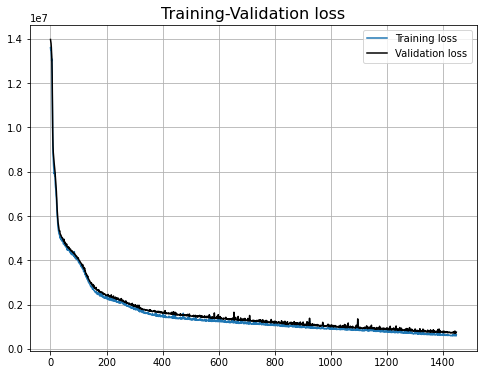

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(train_losses[50:])
plt.plot(val_losses[50:], '-k')
plt.title('Training-Validation loss', fontsize = 16)
plt.grid()
plt.legend(['Training loss','Validation loss'])

# Evalute on the test data

### Scale the test data before evaluating the model

In [ ]:
Test_scaler_x = preprocessing.MinMaxScaler(feature_range=feature_range).fit(X_test) # maybe try another for X?
X_Test_scaled = Test_scaler_x.transform(X_test)

predictions = model(torch.tensor(X_Test_scaled).float()).detach().numpy()
test_targets = y_test.values

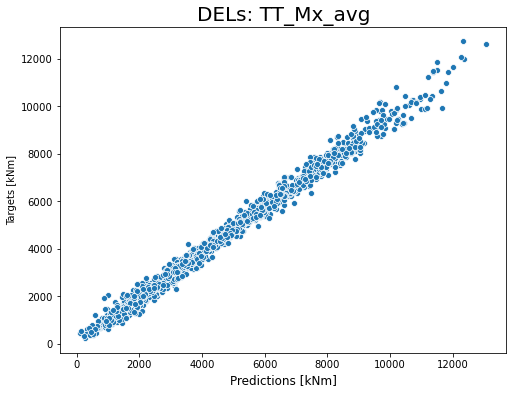

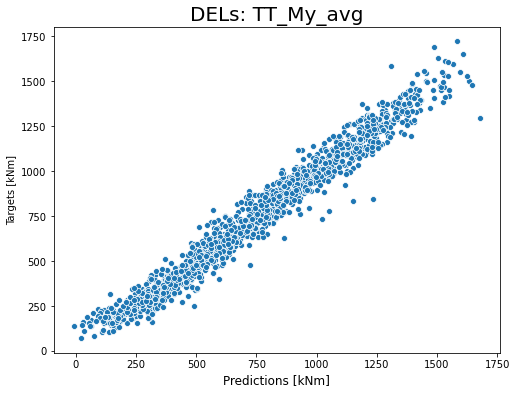

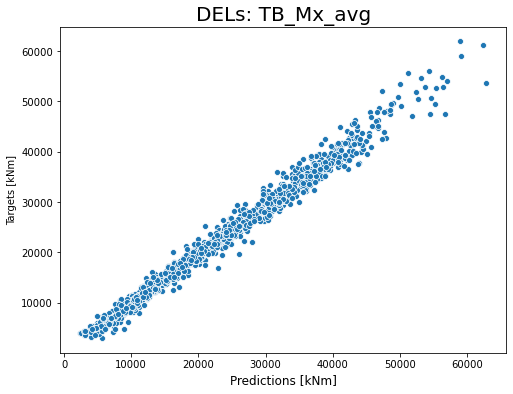

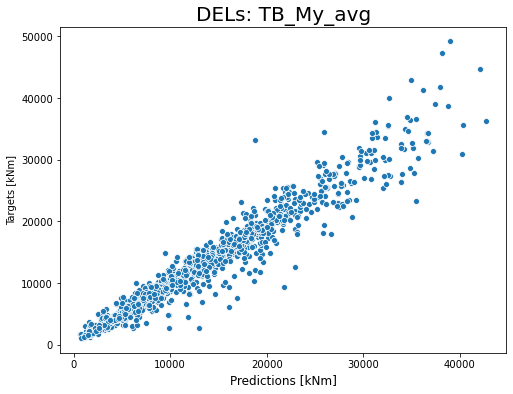

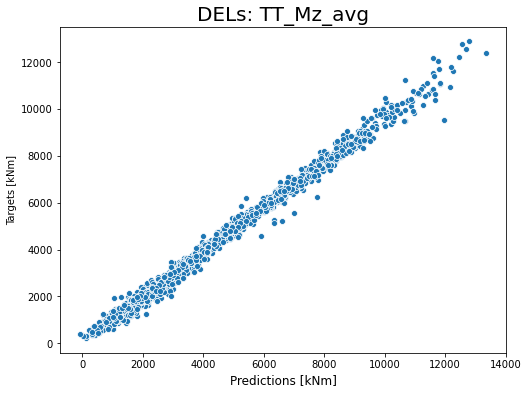

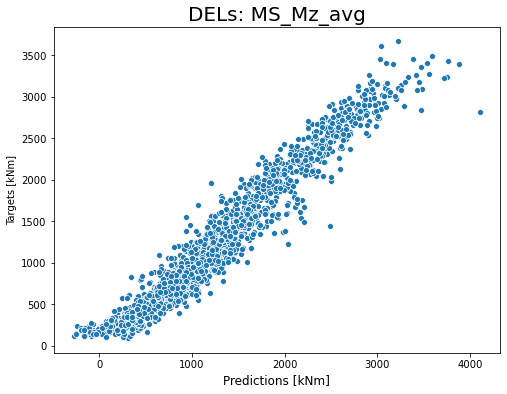

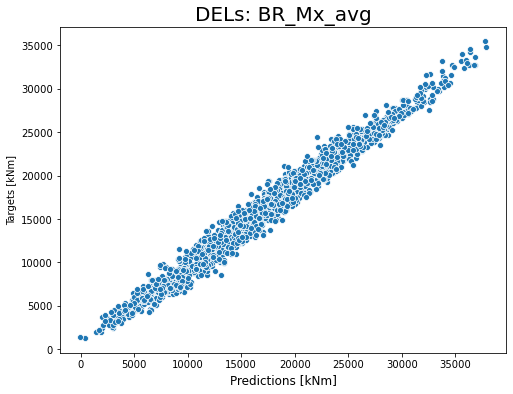

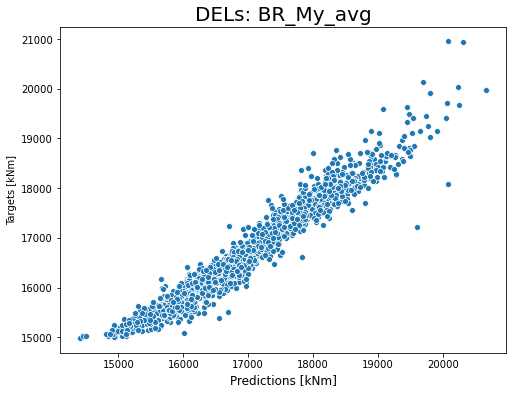

In [ ]:
for idx, ch in enumerate(df.columns.tolist()[8:]):
  # issues with 2 and 7
    plt.figure(idx, figsize = (8,6))
    sns.scatterplot(predictions[:,idx],test_targets[:,idx])
    plt.title(f'DELs: {ch}', fontsize = 20)
    plt.xlabel('Predictions [kNm]', fontsize = 12)
    plt.ylabel('Targets [kNm]')

In [ ]:
mse_list = []
r2_score_list = []
for i in range(len(df.columns.tolist()[8:])):
    #print(f'MSE {AllTargetData.columns[i]} Channel : \n {mean_squared_error(AllTargetData.values[:,i], Yout[:,i])}')
    mse_list.append(mean_squared_error(test_targets[:,i], predictions[:,i]))
    r2_score_list.append(r2_score(test_targets[:,i], predictions[:,i]))
 

 # Compute the normalized mean square error:
Norm_RMSE = np.sqrt(np.array(mse_list)) / y_test.describe().loc['mean'].values

In [ ]:
fig = plt.figure(figsize= (14,4)) 
sns.barplot(x= df.columns.tolist()[8:], y= r2_score_list) 
plt.ylim([min(r2_score_list)*0.92,max(r2_score_list)*1.02])
plt.ylabel('R2 score', fontsize = 20)
plt.grid()

NameError: name 'plt' is not defined

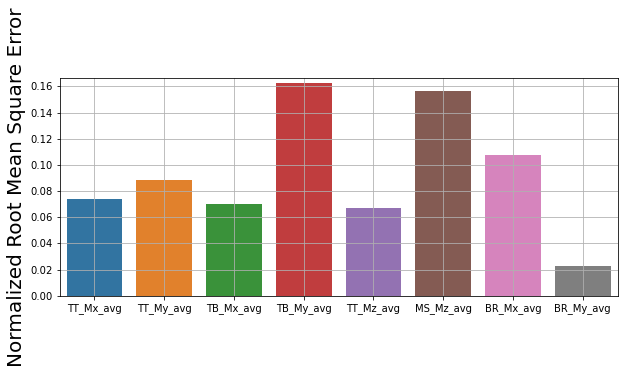

In [ ]:
fig = plt.figure(figsize= (10,4)) 
sns.barplot(x= df.columns.tolist()[8:], y= Norm_RMSE) 
plt.ylim([0,max(Norm_RMSE)*1.02])
plt.ylabel('Normalized Root Mean Square Error', fontsize = 20)
plt.grid()

# ============================================================
# ==========================Section 2 ==========================
# ============================================================
### Compare versus the wind2loads neural net

In [ ]:
error on purpose

SyntaxError: invalid syntax (<ipython-input-21-838280d6483e>, line 1)

In [ ]:
from w2l import neuralnets

In [ ]:
# define the model using the same net architecture, and train for the same number of epochs using the previously batch size as well.
w2l_net = neuralnets.ann(layersizes = [input_size, num_hid_1, num_hid_2, output_channels],
                       params = {'minibatchsize':64, 'nepochs':500}, 
                       output_style = 'None',
                        testratios = [0.7, 0.3, 0.])

In [ ]:
# train using the data from the first split
Outdata = w2l_net.train(X.values,y.values)

Training neural net model:


C:\Users\Bruger\anaconda3\lib\site-packages\w2l\math_utils.py:31: RuntimeWarning: invalid value encountered in true_divide
  rho[0, :M] = (muAB - muA*muB) / \


In [ ]:
w2l_net.params

{'minibatchsize': 64,
 'nepochs': 500,
 'weightinit': [0.01, 0.01, 0.01],
 'regularization': 0.1,
 'learningrate': 0.1,
 'costfunction': 'Lsq',
 'maxiter': 1500,
 'RMSprop': 0.999,
 'Momentum': 0.9,
 'Xscaling': True,
 'Yscaling': True}

In [ ]:
Outdata.keys()

$\color{red}{\text{Why 500 epochs tho}}$

In [ ]:
plt.plot(Outdata['Jhist'][50:])


In [ ]:
Yout = w2l_net.predict(X_test.values) 

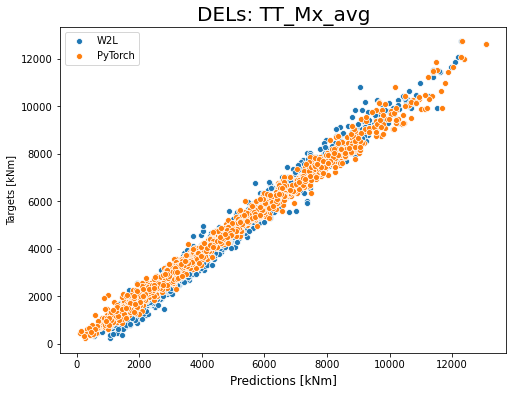

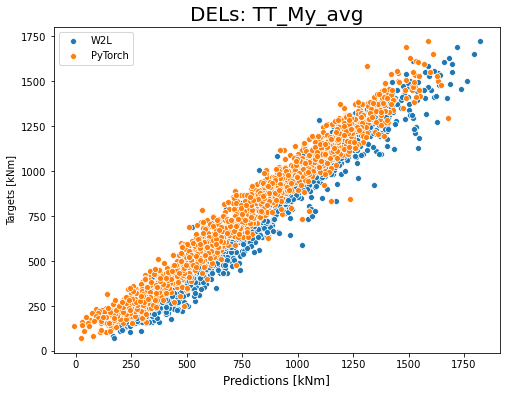

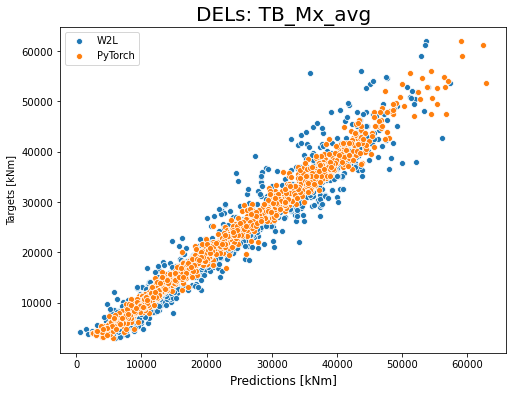

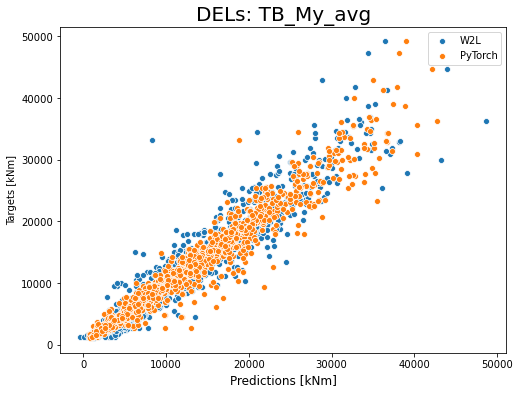

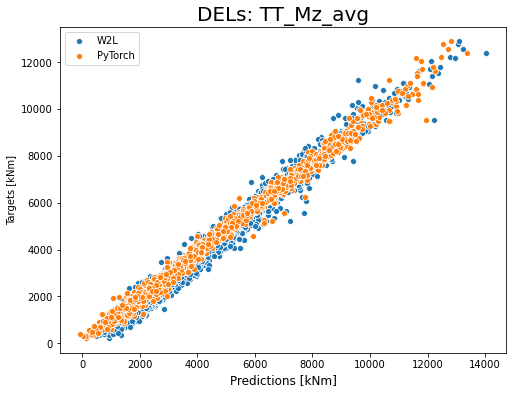

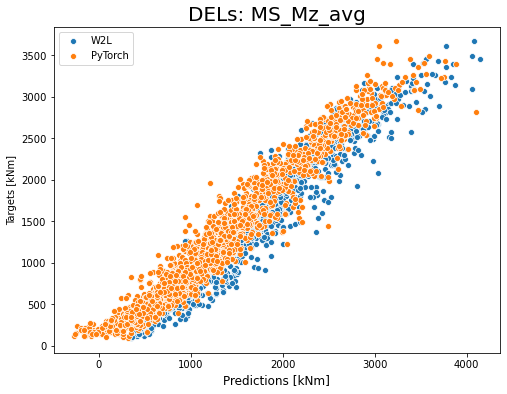

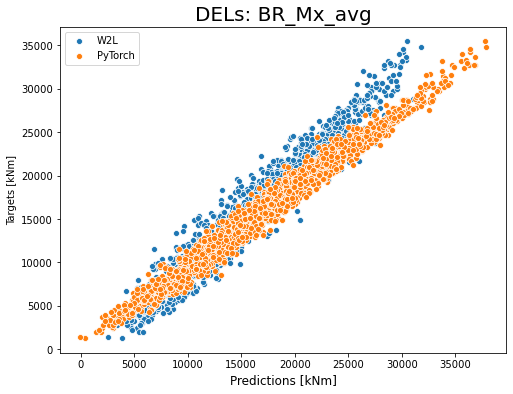

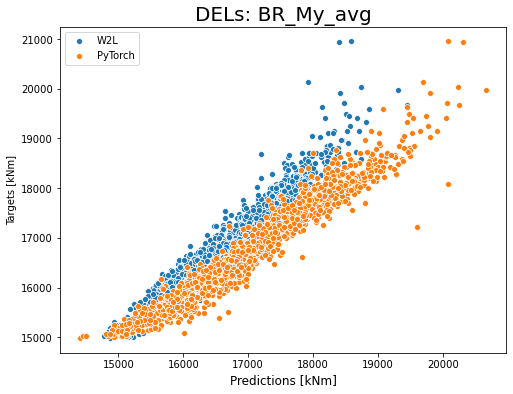

In [ ]:
for idx, ch in enumerate(df.columns.tolist()[8:]):
  # issues with 2 and 7
    plt.figure(idx, figsize = (8,6))
    sns.scatterplot(Yout[:,idx],test_targets[:,idx])
    sns.scatterplot(predictions[:,idx],test_targets[:,idx])
    plt.title(f'DELs: {ch}', fontsize = 20)
    plt.legend(['W2L','PyTorch'])
    plt.xlabel('Predictions [kNm]', fontsize = 12)
    plt.ylabel('Targets [kNm]')

In [ ]:
W2L_mse_list = []
W2L_r2_score_list = []
for i in range(len(df.columns.tolist()[8:])):
    #print(f'MSE {AllTargetData.columns[i]} Channel : \n {mean_squared_error(AllTargetData.values[:,i], Yout[:,i])}')
    W2L_mse_list.append(mean_squared_error(test_targets[:,i], Yout[:,i]))
    W2L_r2_score_list.append(r2_score(test_targets[:,i], Yout[:,i]))
    
W2L_Norm_RMSE = np.sqrt(np.array(W2L_mse_list)) / y_test.describe().loc['mean'].values

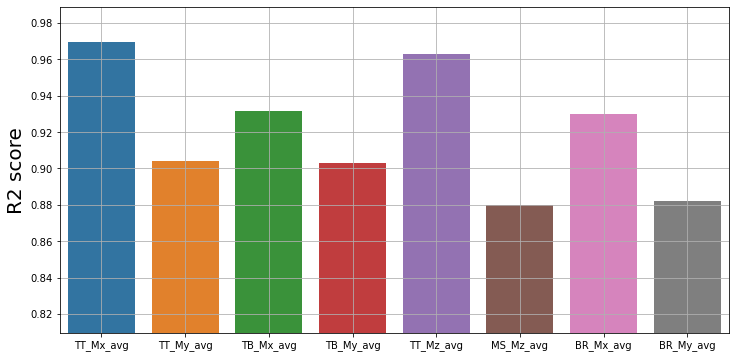

In [ ]:
fig = plt.figure(figsize= (12,6)) 
sns.barplot(x= df.columns.tolist()[8:], y= W2L_r2_score_list) 
plt.ylim([min(W2L_r2_score_list)*0.92,max(W2L_r2_score_list)*1.02])
plt.ylabel('R2 score', fontsize = 20)
plt.grid()

# Compare Wind2Loads net versus PyTorch implementation

In [ ]:
barplot_lst = []
for i,ch in enumerate(df.columns.tolist()[8:]):
    barplot_lst.append(['pytorch',ch,r2_score_list[i]])
for i,ch in enumerate(df.columns.tolist()[8:]):
    barplot_lst.append(['W2L',ch,W2L_r2_score_list[i]])  

In [ ]:
df_comparison = pd.DataFrame(barplot_lst,
                  columns=['Model','channel','r2'])

<Figure size 864x432 with 0 Axes>

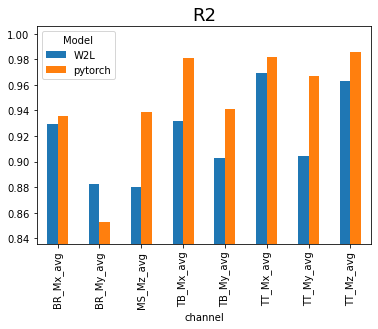

In [ ]:
plt.figure(figsize=(12,6))
df_comparison.pivot("channel", "Model", "r2").plot(kind='bar')
plt.ylim([min(r2_score_list)*0.98,max(r2_score_list)*1.02])
plt.title('R2', fontsize = 18)
plt.show()

In [ ]:
barplot_lst_NMSE = []
for i,ch in enumerate(df.columns.tolist()[8:]):
    barplot_lst_NMSE.append(['pytorch',ch , Norm_RMSE[i]])
for i,ch in enumerate(df.columns.tolist()[8:]):
    barplot_lst_NMSE.append(['W2L', ch, W2L_Norm_RMSE[i]])

In [ ]:
df_NRMSE_comparison = pd.DataFrame(barplot_lst_NMSE,
                  columns=['Model','channel','NRMSE'])



<Figure size 1008x432 with 0 Axes>

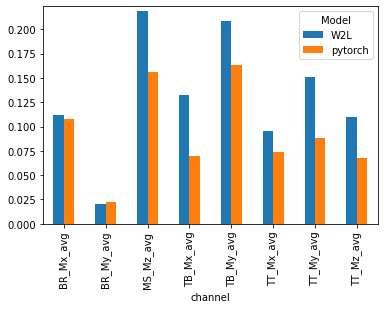

In [ ]:
plt.figure(figsize=(14,6))
df_NRMSE_comparison.pivot("channel", "Model", "NRMSE").plot(kind='bar')
plt.ylim([0,max(W2L_Norm_RMSE)*1.02])
plt.show()